In [59]:
#Python version
!python --version

Python 3.6.13 :: Anaconda, Inc.


In [60]:
#Install uninstalled modules, comment if it's already installed

#!pip install tensorflow==1.15 finta stable-baselines MetaTrader5 gym gym-anytrading quantstats

In [61]:
#Import needed modules
import gym
import gym_anytrading
from gym_anytrading.envs import ForexEnv

import numpy as np
import quantstats as qs

from stable_baselines.a2c import A2C
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpLstmPolicy
from stable_baselines.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

import matplotlib.pyplot as plt
import pandas as pd
from finta import TA

import datetime, os, pytz
import MetaTrader5 as mt5

In [62]:
#Trading Account Parameter
account = 647545 #Account number
password = "QpjpAGkK" #Password number
server = "FBS-Demo" #Server name
mt5_path = "C:\Program Files\FBS MetaTrader 5\terminal64.exe" #path of Metatrader5 director

mt5.initialize(
   path = mt5_path,          # path to the MetaTrader 5 terminal EXE file
   login = account,          # account number
   password = password,      # password
   server = server,          # server name as it is specified in the terminal
   #timeout = TIMEOUT,       # timeout
   portable = False          # portable mode
   )

# display data on the MetaTrader 5 package
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__,"\n")

# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize failed, error code =",mt5.last_error())
    mt5.shutdown()
else:
    print("MetaTrader5 Initialized!")

# extract account information and turn it into dataframe   
authorized=mt5.login(account, password, server)
if authorized:
    # display trading account data 'as is'
    print("Metatrader5 authorized!")
    account_info_dict = mt5.account_info()._asdict()
    Acc_Info = pd.DataFrame(list(account_info_dict.items()),columns=['property','value'])
    print("\n", "account_info() as dataframe:")
    print(Acc_Info)
else:
    print("Metatrader5 cant authorize, error code: {}".format(mt5.last_error()))

MetaTrader5 package author:  MetaQuotes Software Corp.
MetaTrader5 package version:  5.0.34 

MetaTrader5 Initialized!
Metatrader5 authorized!

 account_info() as dataframe:
              property             value
0                login            647545
1           trade_mode                 0
2             leverage              1000
3         limit_orders               100
4       margin_so_mode                 0
5        trade_allowed              True
6         trade_expert              True
7          margin_mode                 2
8      currency_digits                 2
9           fifo_close             False
10             balance            100000
11              credit                 0
12              profit                 0
13              equity            100000
14              margin                 0
15         margin_free            100000
16        margin_level                 0
17      margin_so_call                40
18        margin_so_so                20
19    

In [63]:
#Extract Account info from dataframe
leverage = Acc_Info.loc[2, "value"]
equity = Acc_Info.loc[13, "value"]
margin_free = Acc_Info.loc[15, "value"]

print(leverage)
print(equity)
print(margin_free)

1000
100000.0
100000.0


In [64]:
# extract information from pair and timeframe
Symbol = "EURJPY"
Timeframe = mt5.TIMEFRAME_D1
symbol_info = mt5.symbol_info(Symbol)
if symbol_info!=None:
    # display the terminal data 'as is'    
    print(symbol_info)
    print("\n","{}: spread =".format(Symbol),symbol_info.spread,"  digits =",symbol_info.digits, "\n")
    # Extract symbol info
    
    print(symbol_info[3])

SymbolInfo(custom=False, chart_mode=0, select=True, visible=False, session_deals=0, session_buy_orders=0, session_sell_orders=0, volume=0, volumehigh=0, volumelow=0, time=1624485652, digits=3, spread=21, spread_float=True, ticks_bookdepth=0, trade_calc_mode=0, trade_mode=4, start_time=0, expiration_time=0, trade_stops_level=1, trade_freeze_level=0, trade_exemode=2, swap_mode=1, swap_rollover3days=3, margin_hedged_use_leg=False, expiration_mode=15, filling_mode=3, order_mode=127, order_gtc_mode=0, ...)

 EURJPY: spread = 21   digits = 3 

False


In [65]:
# set time zone to UTC
timezone = pytz.timezone("Etc/UTC")

# getbars from the current day
bar = 500
rates = mt5.copy_rates_from_pos(Symbol, Timeframe, 0, bar)
 
# create DataFrame out of the obtained data
rates_frame = pd.DataFrame(rates, dtype=np.dtype("float"))
# convert time in seconds into the datetime format
rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
                           
# display data
print("\nDisplay dataframe with data")
print(rates_frame)

# turn rates frame into csv file
rates_frame.to_csv('./Datasets/{}.csv'.format(Symbol), index=False)
pd.read_csv('./Datasets/{}.csv'.format(Symbol))


Display dataframe with data
          time     open     high      low    close  tick_volume  spread  \
0   2019-07-19  120.983  121.279  120.793  120.855      94208.0    18.0   
1   2019-07-22  120.823  121.163  120.793  120.898      85222.0    18.0   
2   2019-07-23  120.898  121.090  120.494  120.678      81644.0    18.0   
3   2019-07-24  120.673  120.708  120.206  120.508      79948.0    18.0   
4   2019-07-25  120.512  121.374  120.050  121.086      92672.0    18.0   
..         ...      ...      ...      ...      ...          ...     ...   
495 2021-06-17  132.705  132.873  131.021  131.152      78999.0    16.0   
496 2021-06-18  131.172  131.427  130.601  130.723      63540.0    13.0   
497 2021-06-21  130.636  131.491  130.037  131.333      78553.0    13.0   
498 2021-06-22  131.383  132.191  131.217  132.014      55340.0    16.0   
499 2021-06-23  132.020  132.691  132.020  132.368      54159.0    16.0   

     real_volume  
0            0.0  
1            0.0  
2            

,time,open,high,low,close,tick_volume,spread,real_volume
0,2019-07-19,120.983,121.279,120.793,120.855,94208.0,18.0,0.0
1,2019-07-22,120.823,121.163,120.793,120.898,85222.0,18.0,0.0
2,2019-07-23,120.898,121.090,120.494,120.678,81644.0,18.0,0.0
3,2019-07-24,120.673,120.708,120.206,120.508,79948.0,18.0,0.0
4,2019-07-25,120.512,121.374,120.050,121.086,92672.0,18.0,0.0
...,...,...,...,...,...,...,...,...
495,2021-06-17,132.705,132.873,131.021,131.152,78999.0,16.0,0.0
496,2021-06-18,131.172,131.427,130.601,130.723,63540.0,13.0,0.0
497,2021-06-21,130.636,131.491,130.037,131.333,78553.0,13.0,0.0
498,2021-06-22,131.383,132.191,131.217,132.014,55340.0,16.0,0.0


In [66]:
# read csv from datasets folder
df = pd.read_csv('./Datasets/{}.csv'.format(Symbol))

# turn time coloumn into datetime
df['time'] = pd.to_datetime(df['time'])

#delete empty coloumn
del df['real_volume']

# make indicator coloumns to the dataframe
df['EMA'] = TA.EMA(df, 100, 'open')
df['RSI'] = TA.RSI(df, 14, 'open')
df['ATR'] = TA.ATR(df, 14)
df.fillna(0, inplace=True)

#  rename coloumn's name
df = df.rename(columns={
    "time":"Date",
    "open":"Open",
    "high":"High",
    "low":"Low",
    "close":"Close",
    "tick_volume":"Tick_volume",
    "spread":"Spread",
})

# set Date coloumn as index
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Tick_volume,Spread,EMA,RSI,ATR
Date,,,,,,,,,
2019-07-19,120.983,121.279,120.793,120.855,94208.0,18.0,120.983000,0.000000,0.000000
2019-07-22,120.823,121.163,120.793,120.898,85222.0,18.0,120.902200,0.000000,0.000000
2019-07-23,120.898,121.090,120.494,120.678,81644.0,18.0,120.900772,33.546326,0.000000
2019-07-24,120.673,120.708,120.206,120.508,79948.0,18.0,120.842109,16.098597,0.000000
2019-07-25,120.512,121.374,120.050,121.086,92672.0,18.0,120.773420,11.492474,0.000000
...,...,...,...,...,...,...,...,...,...
2021-06-17,132.705,132.873,131.021,131.152,78999.0,16.0,130.532841,48.037651,0.642643
2021-06-18,131.172,131.427,130.601,130.723,63540.0,13.0,130.545498,34.301760,0.675929
2021-06-21,130.636,131.491,130.037,131.333,78553.0,13.0,130.547291,30.967575,0.742714


In [67]:
# make a custom signal parameter from a spesific data
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Open'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Open', 'EMA', 'RSI']].to_numpy()[start:end]
    return prices, signal_features

class MyCustomEnv(ForexEnv):
    _process_data = add_signals


env information:
> shape: (12, 3)
> df.shape: (500, 9)
> prices.shape: (500,)
> signal_features.shape: (500, 3)
> max_possible_profit: 2.366904207281631


> possible action: Discrete(2)
> observation space: Box(-inf, inf, (12, 3), float32)


> signal features:  [[120.983      120.983        0.        ]
 [120.823      120.9022       0.        ]
 [120.898      120.90077191  33.54632588]
 ...
 [130.636      130.54729052  30.96757538]
 [131.383      130.56383999  39.75629082]
 [132.02       130.59267615  46.06247699]]


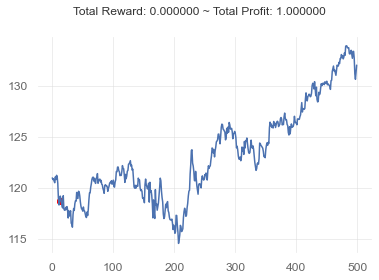

               Open     High      Low    Close  Tick_volume  Spread  \
Date                                                                  
2019-07-19  120.983  121.279  120.793  120.855      94208.0    18.0   
2019-07-22  120.823  121.163  120.793  120.898      85222.0    18.0   
2019-07-23  120.898  121.090  120.494  120.678      81644.0    18.0   
2019-07-24  120.673  120.708  120.206  120.508      79948.0    18.0   
2019-07-25  120.512  121.374  120.050  121.086      92672.0    18.0   
...             ...      ...      ...      ...          ...     ...   
2021-06-17  132.705  132.873  131.021  131.152      78999.0    16.0   
2021-06-18  131.172  131.427  130.601  130.723      63540.0    13.0   
2021-06-21  130.636  131.491  130.037  131.333      78553.0    13.0   
2021-06-22  131.383  132.191  131.217  132.014      55340.0    16.0   
2021-06-23  132.020  132.691  132.020  132.368      54159.0    16.0   

                   EMA        RSI       ATR  
Date                          

In [68]:
# build the gym environment
window_size = 12
start_index = window_size
end_index = len(df)
env = MyCustomEnv(df = df,
               window_size = start_index,
               frame_bound = (start_index, end_index), #Max 6225 Rows of data
               unit_side = 'right')

# get information from the environment
print()
print("env information:")
print("> shape:", env.shape)
print("> df.shape:", env.df.shape)
print("> prices.shape:", env.prices.shape)
print("> signal_features.shape:", env.signal_features.shape)
print("> max_possible_profit:", env.max_possible_profit())
print("\n")
print("> possible action:", env.action_space)
print("> observation space:", env.observation_space)
print("\n")
print("> signal features: ", env.signal_features)

env.reset() # Uncomment if you need it.
env.render()

print(env.df)
print("\n")
env.df.info()

info: {'total_reward': -98809.99999999814, 'total_profit': 1.007515014913754, 'position': 0}


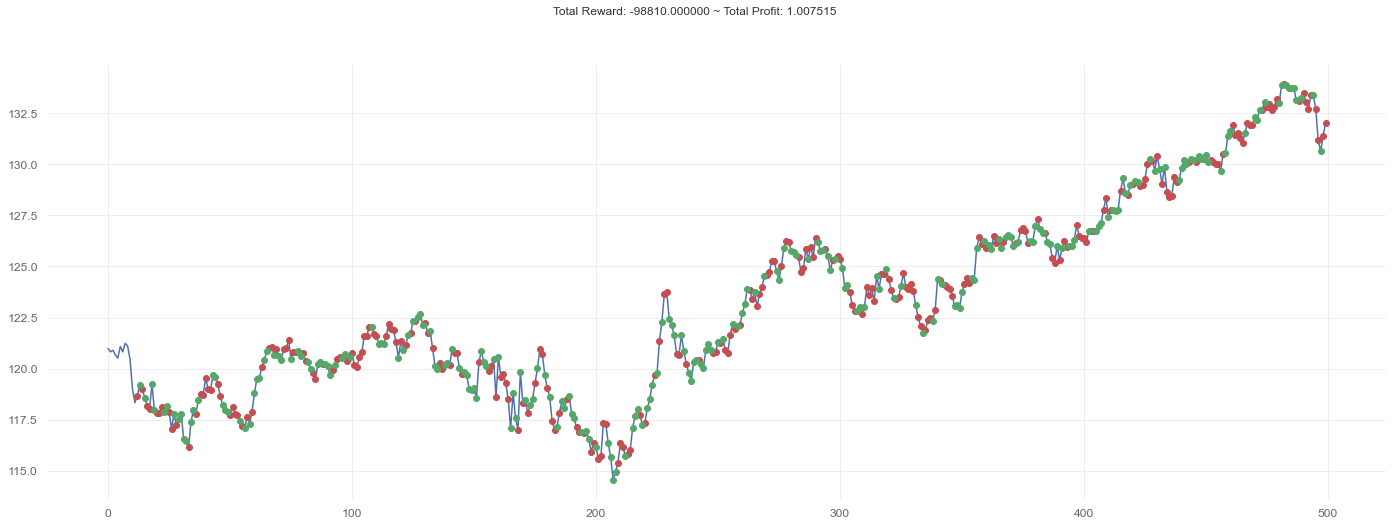

Date
2019-08-08   -0.001747
2019-08-09    0.000000
2019-08-12   -0.003333
2019-08-13    0.000000
2019-08-14    0.000000
                ...   
2021-06-17   -0.004966
2021-06-18    0.000000
2021-06-21    0.000000
2021-06-22    0.005716
2021-06-23    0.000000
Length: 486, dtype: float64 



                           Strategy
-------------------------  ----------
Start Period               2019-08-08
End Period                 2021-06-23
Risk-Free Rate             0.0%
Time in Market             27.0%

Cumulative Return          0.75%
CAGR%                      0.4%

Sharpe                     0.1
Sortino                    0.15
Sortino/√2                 0.1

Max Drawdown               -8.17%
Longest DD Days            475
Volatility (ann.)          4.87%
Calmar                     0.05
Skew                       -0.11
Kurtosis                   8.72

Expected Daily %           0.0%
Expected Monthly %         0.03%
Expected Yearly %          0.25%
Kelly Criterion            1.62%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.5%
Expected Shortfall (cVaR)  -0.5%

Gain/Pain Ratio            0.03
Gain/Pain (1M)             0.07

Payoff Ratio               1.03
Profit Factor              1.03
Common Sense Ratio         1.04
CPC Index                  0.53
Tail

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-01-21,2020-05-11,2021-05-10,475,-8.166731,-8.093174
2,2019-08-12,2019-10-04,2020-01-07,148,-3.450616,-3.245232
3,2021-06-08,2021-06-17,2021-06-23,15,-0.917113,-0.587264
4,2021-05-20,2021-05-20,2021-05-31,11,-0.182853,0.000000


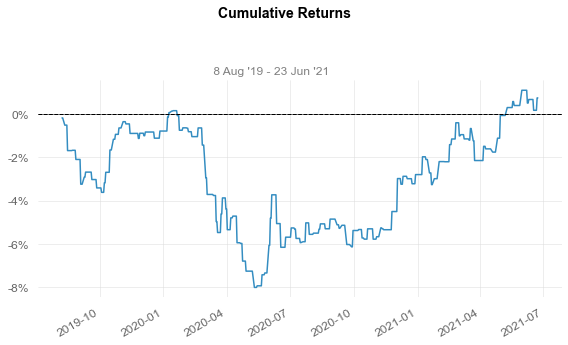

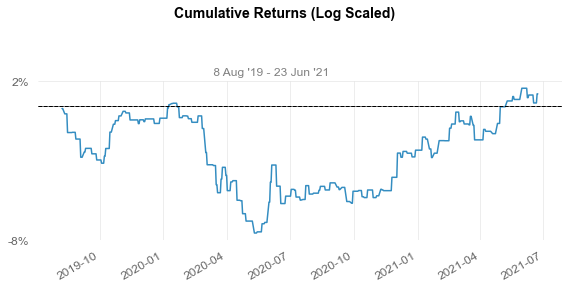

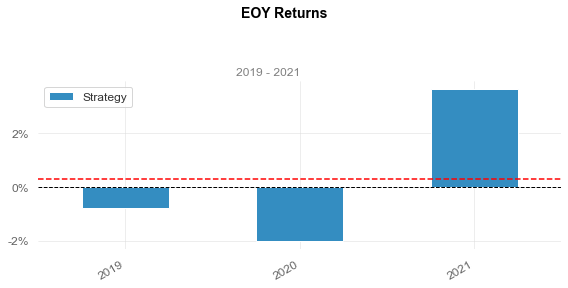

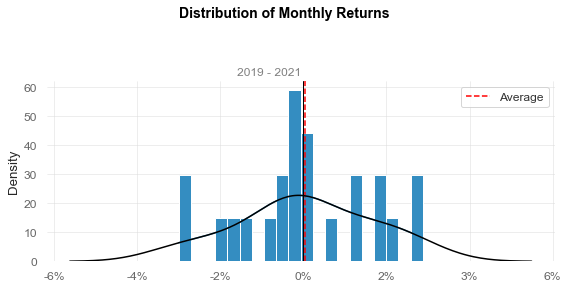

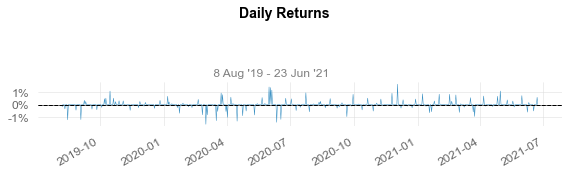

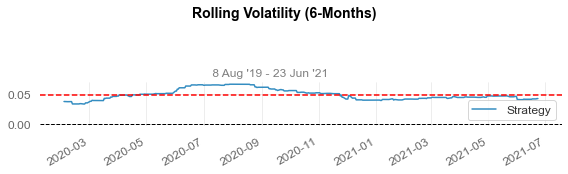

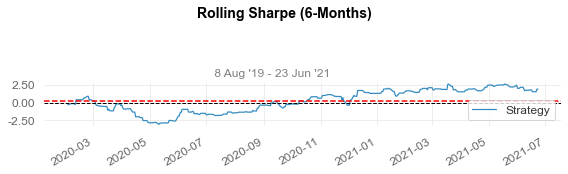

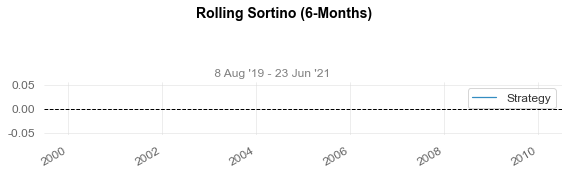

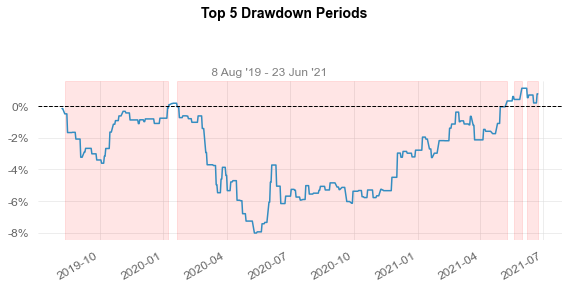

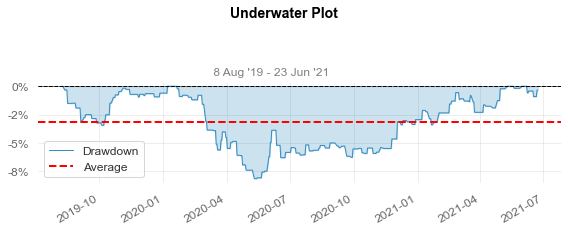

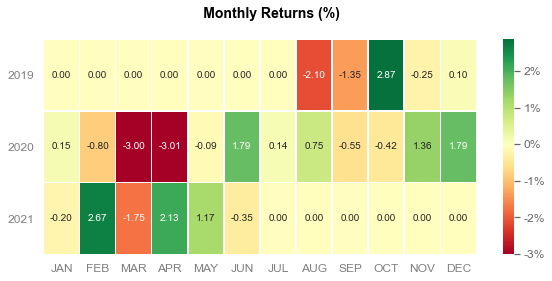

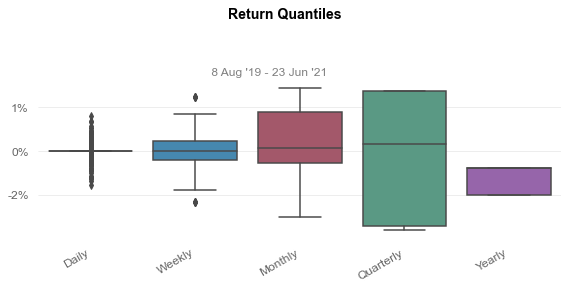

In [69]:
# make a prediction based on random actions

observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    # env.render()
    if done:
        print("info:", info)
        break

plt.figure(figsize=(24, 8))
plt.cla()
env.render_all()
plt.show()

# create a quantstats result for a comparison
qs.extend_pandas()
net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

print(returns,'\n')

qs.reports.full(returns)
qs.reports.html(returns, output='./Random Result/random quantstats.html'.format(Symbol, Timeframe))

In [70]:
env_maker = lambda: env
env = DummyVecEnv([env_maker])

In [54]:
timesteps = 50000

eval_callback = EvalCallback(
    env,
    best_model_save_path='./Saved_Model/{}-{}-Model_{}'.format(Symbol, Timeframe, timesteps),
    log_path='./logs/{}_{}'.format(Symbol, Timeframe),
    eval_freq=100,
    deterministic=True,
    render=False,
    )

policy_kwargs = dict(net_arch=[32, 32, 'lstm'])

model = A2C(
    'MlpLstmPolicy',
    env,
    gamma=0.95,
    learning_rate=0.002,
    verbose=1,
    policy_kwargs=policy_kwargs,
    ) 

model.learn(
    total_timesteps=timesteps,
    callback=eval_callback,
    )

## model.save('./Saved_Model/{}-{}-Model_{}/best_model.zip'.format(Symbol, Timeframe, timesteps))

---------------------------------
| explained_variance | 8.82e-05 |
| fps                | 15       |
| nupdates           | 1        |
| policy_entropy     | 0.693    |
| total_timesteps    | 5        |
| value_loss         | 2.38e+04 |
---------------------------------
Eval num_timesteps=100, episode_reward=-1000.00 +/- 0.00
Episode length: 487.00 +/- 0.00
New best mean reward!
Eval num_timesteps=200, episode_reward=-1120.00 +/- 0.00
Episode length: 487.00 +/- 0.00


KeyboardInterrupt: 

In [71]:
# delete model dan loading from saved folder, comment if you didn't need it
# del model # remove model for saving and loading
## model = A2C.load('./Saved_Model/{}-{}-Model_{}/best_model.zip'.format(Symbol, Timeframe, timesteps))
model = A2C.load('D:\TugasKampus\Fun Project\MT5_TensorDL\model vault\EURUSD-30-Model_50000/best_model.zip')

env = MyCustomEnv(df = df,
               window_size = start_index,
               frame_bound = (start_index, end_index), #Max 6225 Rows of data
               unit_side = 'right')


observation = env.reset()

while True:
    observation = observation[np.newaxis, ...]

    action, _states = model.predict(observation)
    observation, reward, done, info = env.step(action)

    if done:
        print("info:", info)
        break

Loading a model without an environment, this model cannot be trained until it has a valid environment.
info: {'total_reward': 87860.00000000029, 'total_profit': 1.0939393120056082, 'position': 0}


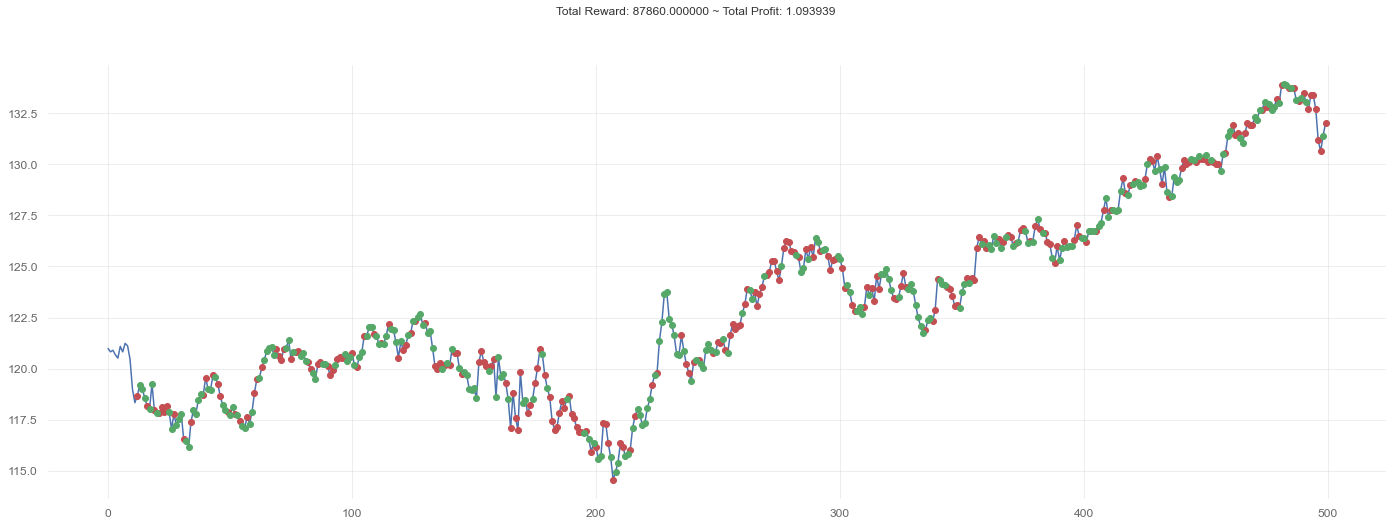

In [72]:
# gets result from trained model
plt.figure(figsize=(24, 8))
env.render_all()
plt.show()

Date
2019-08-08    0.000000
2019-08-09    0.000000
2019-08-12   -0.008517
2019-08-13    0.000000
2019-08-14    0.000000
                ...   
2021-06-17    0.000000
2021-06-18    0.000000
2021-06-21    0.000000
2021-06-22    0.000000
2021-06-23    0.004846
Length: 486, dtype: float64 



                           Strategy
-------------------------  ----------
Start Period               2019-08-08
End Period                 2021-06-23
Risk-Free Rate             0.0%
Time in Market             27.0%

Cumulative Return          9.39%
CAGR%                      4.9%

Sharpe                     1.06
Sortino                    1.63
Sortino/√2                 1.16

Max Drawdown               -4.73%
Longest DD Days            183
Volatility (ann.)          4.48%
Calmar                     1.04
Skew                       0.19
Kurtosis                   10.39

Expected Daily %           0.02%
Expected Monthly %         0.39%
Expected Yearly %          3.04%
Kelly Criterion            16.45%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.45%
Expected Shortfall (cVaR)  -0.45%

Gain/Pain Ratio            0.41
Gain/Pain (1M)             1.01

Payoff Ratio               1.1
Profit Factor              1.41
Common Sense Ratio         2.4
CPC Index                  0.87


None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-01-06,2020-04-28,2020-07-07,183,-4.728741,-4.547208
2,2020-09-03,2020-11-16,2021-02-26,176,-3.921440,-3.651550
3,2021-03-22,2021-03-25,2021-05-07,46,-1.676286,-1.203328
4,2019-08-12,2019-09-02,2019-09-18,37,-1.636795,-1.041525
5,2019-09-20,2019-10-03,2019-10-11,21,-0.770531,-0.558783


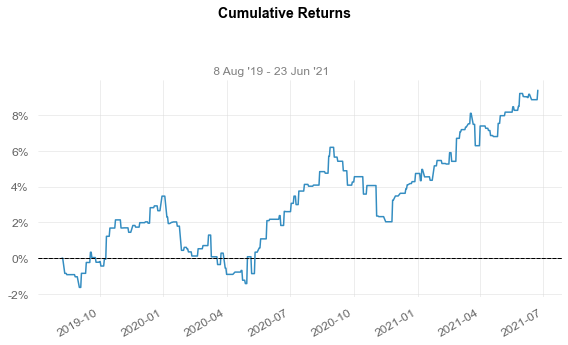

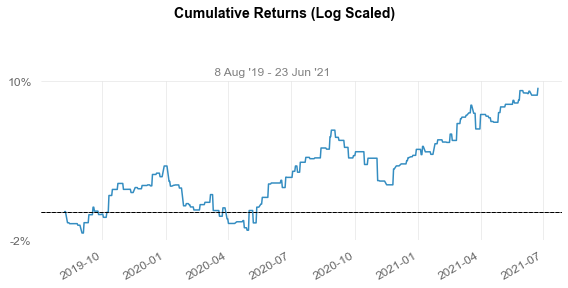

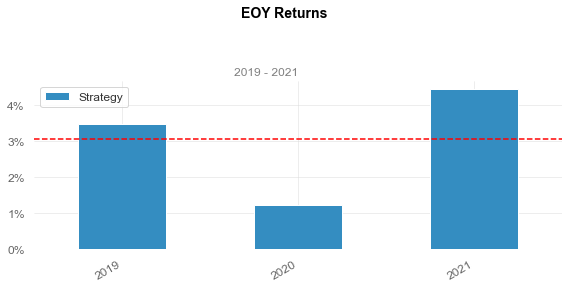

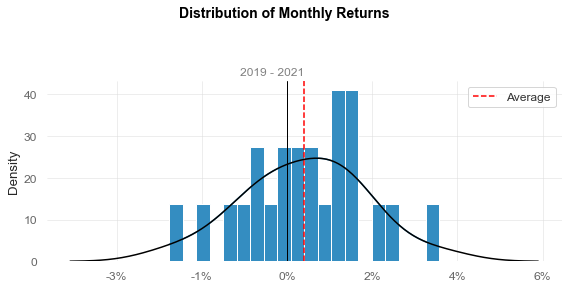

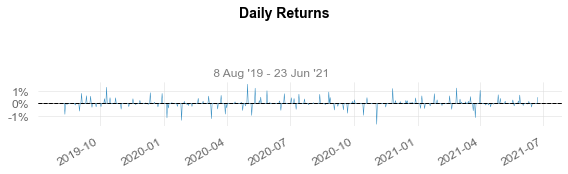

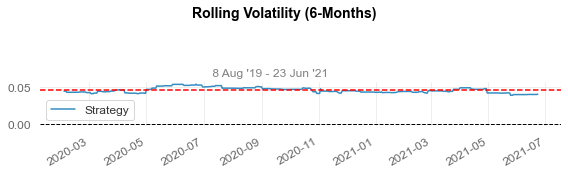

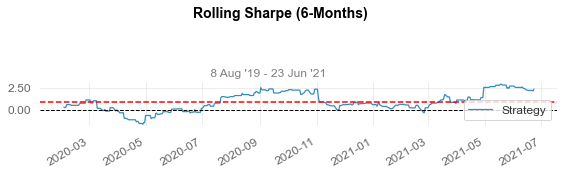

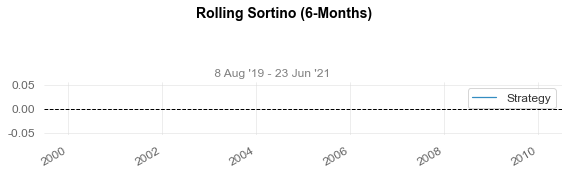

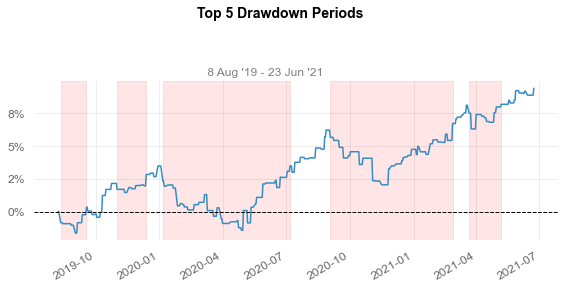

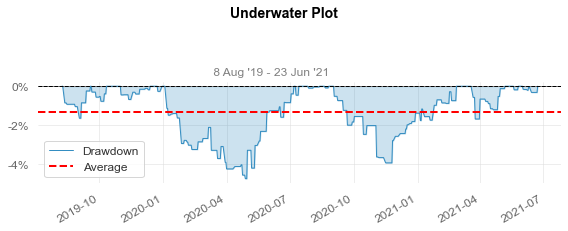

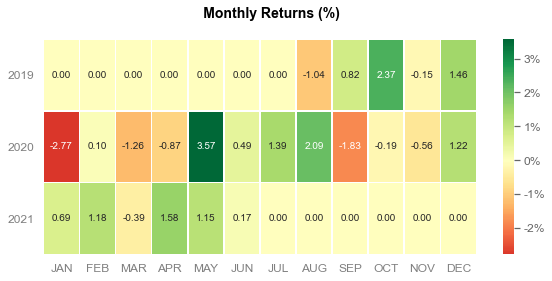

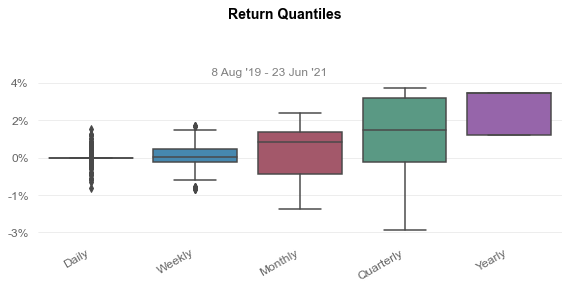

In [73]:
# gets full result from trained model
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

print(returns,'\n')

qs.reports.full(returns)
qs.reports.html(returns, output='./Backtesting/{}_{}_{}_quantstats.html'.format(Symbol, Timeframe, timesteps))